In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
sess = tf.Session(config=tf_config)

In [2]:
import keras
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.optimizers import Optimizer
from keras import callbacks

import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from IPython.display import Image

np.random.seed(17)

Using TensorFlow backend.


In [3]:
keras.__version__

'2.0.8'

In [4]:
tf.__version__

'1.3.0'

### Task Description
- Sequence-to-sequence encoder-decoder model in Keras
- Task of text summarization
- Dataset: Amazon reviews and summaries from Kaggle https://www.kaggle.com/snap/amazon-fine-food-reviews
- only a 100k subset of this dataset is used

In [5]:
DATA_FILE_PATH = 'data/amazon_reviews.csv' 
EMB_DIR = '/collection/hpallika/deeplearning/research_work/word_embeddings/glove.6B.300d.txt'

MAX_TEXT_VOCAB_SIZE = 30000
MAX_SUMMARY_VOCAB_SIZE = 10000
MAX_TEXT_LEN = 100
MAX_SUMMARY_LEN = 5

LSTM_DIM = 300
EMBEDDING_DIM = 300

BATCH_SIZE = 128
N_EPOCHS = 1

In [6]:
df = pd.read_csv(DATA_FILE_PATH)
print('Number of rows = ', df.shape[0])
df.head(10)

Number of rows =  100000


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...
5,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,Yay Barley,Right now I'm mostly just sprouting this so my...
9,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [7]:
# Converting all columns to string
df['Summary'] = df['Summary'].apply(lambda x: str(x))
df['Text'] = df['Text'].apply(lambda x: str(x))

In [8]:
sent_len = lambda x:len(x)
df['Summary_length'] = df.Summary.apply(sent_len)
df[df['Summary_length']<5]['Summary'].tail()

99697    WOW!
99750    Whoa
99797     yuk
99880    Yum!
99929     WOW
Name: Summary, dtype: object

Summaries having lesser than 5 characters can be discarded - noisy data, which is about 1500 rows of the data

In [9]:
# Summaries having lesser than 5 characters can be discarded - noisy data
indices = df[df['Summary_length']<5].index
df.drop(indices, inplace=True)

# Can drop the Summary_length columns - to save memory
df.drop('Summary_length', inplace=True, axis=1)

df.reset_index(inplace=True, drop=True)
df.shape

(98491, 2)

In [10]:
word_count = lambda x:len(x.split()) # Word count for each question
df['s_wc'] = df.Summary.apply(word_count)
df['t_wc'] = df.Text.apply(word_count)

p = 75.0

print(' Summary :{} % of the summaries have a length less than or equal to {}'.format(p, np.percentile(df['s_wc'], p)))
print(' Text :{} % of the texts have a length less than or equal to {}'.format(p, np.percentile(df['t_wc'], p)))

 Summary :75.0 % of the summaries have a length less than or equal to 5.0
 Text :75.0 % of the texts have a length less than or equal to 100.0


Use the above stats to decide on the MAX number of tokens of the encoder and decoder sides

In [11]:
text_list = [' '.join(word_tokenize(x)[:MAX_TEXT_LEN]) for x in df['Text']]
text_list[:2]

['I have bought several of the Vitality canned dog food products and have found them all to be of good quality . The product looks more like a stew than a processed meat and it smells better . My Labrador is finicky and she appreciates this product better than most .',
 "Product arrived labeled as Jumbo Salted Peanuts ... the peanuts were actually small sized unsalted . Not sure if this was an error or if the vendor intended to represent the product as `` Jumbo '' ."]

In [12]:
summary_list = [' '.join(word_tokenize(x)[:MAX_SUMMARY_LEN]) for x in df['Summary']]
summary_list[:2]

['Good Quality Dog Food', 'Not as Advertised']

### Separate embedding matrices - one for encoder side (Texts), one for decoder side (Summary)

- We could use a shared embedding matrix if the source and target have similar vocabularies (same size and same domain). Eg. for dialogue generation


- If the vocabularies are different, e.g., machine translation, we definitely need to use different embedding matrices


- In this case, the summaries (decoder side) will have a smaller vocabulary than the texts (source side). It is not efficient to use a shared vocabulary/shared embedding matrix. For example, on the decoder side if we have 30,000 words vs. 5,000 words -> it is more difficult for the decoder (the softmax) to select 1 word from 30,000 choices vs. 1 from 5,000.


### Preparing the word-to-index mapping
Special tokens
- PAD 
- SOS (only required for the decoder input, for the 1st timestep to inform the decoder that it can now start decoding)
- EOS
- UNK

In [13]:
filter_list = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

text_tokenizer = Tokenizer(filters=filter_list)
text_tokenizer.fit_on_texts(text_list)
print("Number of words in TEXT vocabulary:", len(text_tokenizer.word_index))

summary_tokenizer = Tokenizer(filters=filter_list)  
summary_tokenizer.fit_on_texts(summary_list)
print("Number of words in SUMMARY vocabulary:", len(summary_tokenizer.word_index))

Number of words in TEXT vocabulary: 45418
Number of words in SUMMARY vocabulary: 13409


In [14]:
text_word_index = {}
text_word_index['PAD'] = 0
text_word_index['UNK'] = 1
text_word_index['EOS'] = 2

for i, word in enumerate(dict(text_tokenizer.word_index).keys()):
    text_word_index[word] = i+3 # Move existing indices up by 3 places
    
text_tokenizer.word_index = text_word_index
X = text_tokenizer.texts_to_sequences(text_list)

# Replace OOV words with UNK token
# Append EOS to the end of all sentences
for i, seq in enumerate(X):
    if any(t>=MAX_TEXT_VOCAB_SIZE for t in seq):
        seq = [t if t<MAX_TEXT_VOCAB_SIZE else text_word_index['UNK'] for t in seq ]
    seq.append(text_word_index['EOS'])
    X[i] = seq    
    
# Padding and truncating sequences
X = pad_sequences(X, padding='post', truncating='post', maxlen=MAX_TEXT_LEN, value=text_word_index['PAD'])

# Finalize the dictionaries
text_word_index = {k: v for k, v in text_word_index.items() if v < MAX_TEXT_VOCAB_SIZE} 
text_idx_to_word = dict((i, word) for word, i in text_word_index.items()) 

In [15]:
summary_word_index = {}
summary_word_index['PAD'] = 0
summary_word_index['UNK'] = 1
summary_word_index['EOS'] = 2
summary_word_index['SOS'] = 3

for i, word in enumerate(dict(summary_tokenizer.word_index).keys()):
    summary_word_index[word] = i+4 # Move existing indices up by 4 places
    
summary_tokenizer.word_index = summary_word_index
Y = summary_tokenizer.texts_to_sequences(summary_list)

# Replace OOV words with UNK token
# Append EOS to the end of all sentences
for i, seq in enumerate(Y):
    if any(t>=MAX_SUMMARY_VOCAB_SIZE for t in seq):
        seq = [t if t<MAX_SUMMARY_VOCAB_SIZE else summary_word_index['UNK'] for t in seq ]
    seq.append(summary_word_index['EOS'])
    Y[i] = seq    
    
# Padding and truncating sequences
Y = pad_sequences(Y, padding='post', truncating='post', maxlen=MAX_SUMMARY_LEN, value=summary_word_index['PAD'])

# Finalize the dictionaries
summary_word_index = {k: v for k, v in summary_word_index.items() if v < MAX_SUMMARY_VOCAB_SIZE} 
summary_idx_to_word = dict((i, word) for word, i in summary_word_index.items()) 

### Train-Validation-Test Splits

In [16]:
X_train, X_val_test, Y_train, Y_val_test = train_test_split(X, Y, test_size=0.05)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, test_size=0.5)

### Embedding Matrix

In [17]:
# Load GloVe word embeddings 
# Download Link: https://nlp.stanford.edu/projects/glove/
print("[INFO]: Reading Word Embeddings ...")
# Data path
embeddings = {}
f = open(EMB_DIR)
for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    embeddings[word] = vector
f.close()

[INFO]: Reading Word Embeddings ...


In [18]:
encoder_embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(text_word_index), EMBEDDING_DIM)) 

for word, i in text_word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    if embeddings_vector is not None:
        encoder_embeddings_matrix[i] = embeddings_vector

In [19]:
print(encoder_embeddings_matrix.shape)

(30000, 300)


In [20]:
decoder_embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(summary_word_index), EMBEDDING_DIM)) 

for word, i in summary_word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    if embeddings_vector is not None:
        decoder_embeddings_matrix[i] = embeddings_vector
        
del embeddings

In [21]:
print(decoder_embeddings_matrix.shape)

(10000, 300)


### Model during training
Input: [where, do, you, live, ?, EOS] <br>
Output: [I, reside, in, waterloo, EOS] <br>
When the model predicts wrongly, we need to correct it so that errors are not accumulated. __TEACHER FORCING__

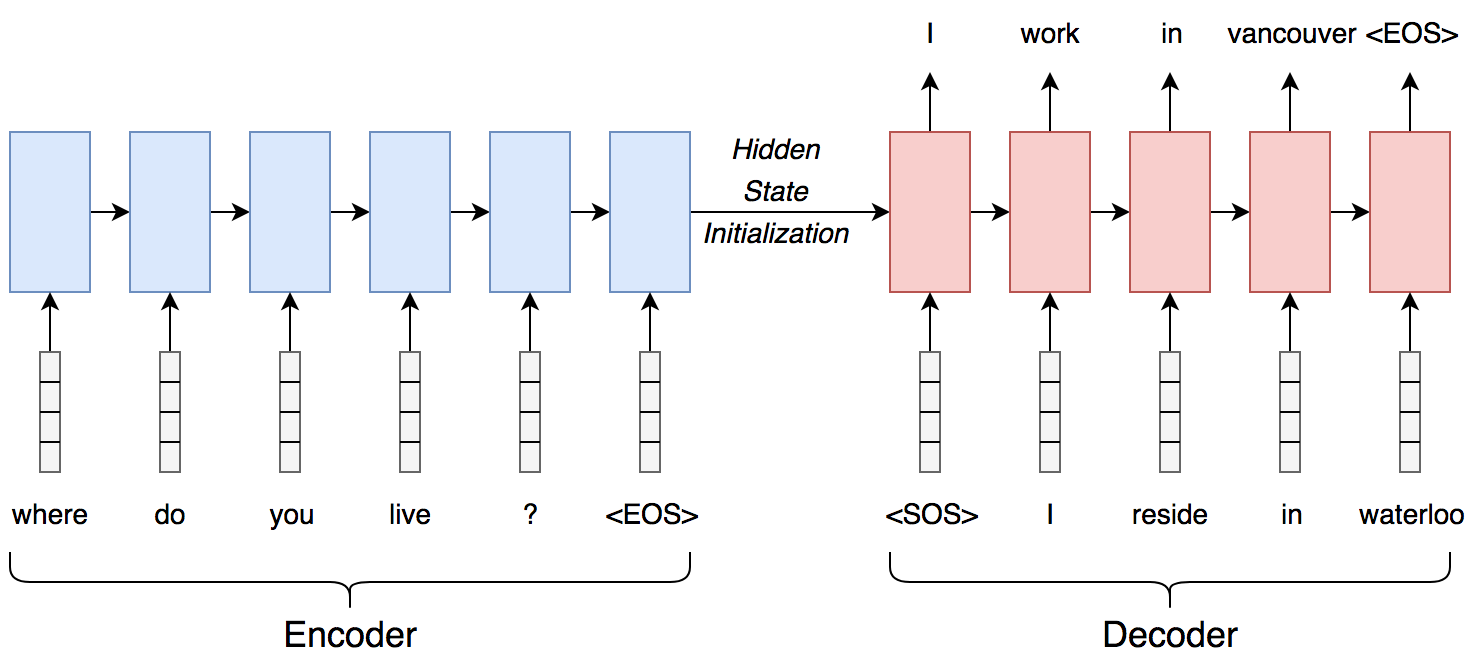

In [22]:
Image('images/seq2seq-training.png', width=800)

### Keras Model Building
Adapted from Keras blog post:
https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [23]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
from keras import backend as K

When the datasets are huge, it is a good idea to make use of the keras fit_generator. <br>
Basically, we need to generator function that feeds inputs and corresponding outputs in a batch_wise fashion. <br>

In our case, we have 
- encoder inputs
- decoder inputs (which is the ground truth delayed by 1 timestep)
- decoder outputs 

For decoder outputs for each token, we need to predict a softmax of the vocabulary |V|. If we have _m_ tokens and a training data size of _n_, we need to store a huge tensor of size _n_ x _m_ x |V|. In our case, 100000 x 5 x 10000.
<br>

This may not fit in memory. Even if it fits, it is not a good practice to keep such large variables, hence use the fit generator

In [24]:
def batch_generator(X, Y, BATCH_SIZE):

    # this line is just to make the generator infinite, keras needs that    
    while True:
        
        batch_start = 0
        batch_end = BATCH_SIZE

        while batch_start < len(X):
            
            [X_enc, X_dec], Y_dec = prepare_data(X, Y, batch_start, batch_end)
            
            yield ([X_enc, X_dec], Y_dec) 

            batch_start += BATCH_SIZE   
            batch_end += BATCH_SIZE

In [25]:
def prepare_data(X, Y, batch_start, batch_end):
    
    # Encoder input
    X_enc = X[batch_start:batch_end] 

    # Decoder input
    # Concatenate a column of 3s (i.e., SOS token) to the Y and remove the last element
    X_dec = np.c_[3 * np.ones([len(Y[batch_start:batch_end])]), Y[batch_start:batch_end, :-1]]

    # Decoder output - one hot encoded for softmax layer - 1 in |V|
    Y_dec = np.array([to_categorical(y, num_classes=len(summary_word_index)) for y in Y[batch_start:batch_end]])

    return [X_enc, X_dec], Y_dec

Sequence-to-sequence model for __training__:

In [26]:
K.set_learning_phase(1) # 1 for training, 0 for inference time

In [27]:
# Encoder Setup
enc_input = Input(shape=(MAX_TEXT_LEN, ), name='encoder_input')
enc_emb_look_up = Embedding(input_dim=MAX_TEXT_VOCAB_SIZE,
                             output_dim=EMBEDDING_DIM,
                             weights = [encoder_embeddings_matrix], 
                             trainable=False, 
                             mask_zero=True,
                             name='encoder_embedding_lookup')

enc_emb_text = enc_emb_look_up(enc_input)

encoder_lstm = LSTM(LSTM_DIM, return_state=True, name='encoder_lstm', dropout=0.2) # To return the final state of the encoder
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb_text)
encoder_states = [state_h, state_c] # Discard encoder_outputs (at each time step) and only keep the final states.

In [28]:
# Decoder Setup
dec_input = Input(shape=(None, ), name='decoder_input') # Specify None instead of MAX_SUMMARY_LEN
# So that we can use the decoder with one-token prediction at a time
# By specifying MAX_SUMMARY_LEN, we limit this capability of the decoder
# That is, if MAX_SUMMARY_LEN is specified, we always have to provide MAX_SUMMARY_LEN tokens as input to the decoder
# By not specifying, we can dynamically adjust it, i.e., MAX_SUMMARY_LEN during training and 1 during inference

dec_emb_look_up = Embedding(input_dim=MAX_SUMMARY_VOCAB_SIZE,
                             output_dim=EMBEDDING_DIM,
                             weights = [decoder_embeddings_matrix], 
                             trainable=False, 
                             mask_zero=True,
                             name='decoder_embedding_lookup')

dec_emb_text = dec_emb_look_up(dec_input)

# We set up our decoder to return full output sequences,
# and to return internal LSTM states (h, c) as well. We don't use the 
# return states in the training model, but we will use them during inference.
decoder_lstm = LSTM(LSTM_DIM, return_sequences=True, return_state=True, name='decoder_lstm', dropout=0.2)
# Dropout needs to be set back to 0.0 for the inference time

# Hidden state initialization using `encoder_states` as initial state.
decoder_outputs, _, _ = decoder_lstm(dec_emb_text,
                                     initial_state=encoder_states)

decoder_dense = Dense(MAX_SUMMARY_VOCAB_SIZE, activation='softmax', name='output_layer')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([enc_input, dec_input], decoder_outputs)

In [29]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
encoder_input (InputLayer)       (None, 100)           0                                            
____________________________________________________________________________________________________
decoder_input (InputLayer)       (None, None)          0                                            
____________________________________________________________________________________________________
encoder_embedding_lookup (Embedd (None, 100, 300)      9000000     encoder_input[0][0]              
____________________________________________________________________________________________________
decoder_embedding_lookup (Embedd (None, None, 300)     3000000     decoder_input[0][0]              
___________________________________________________________________________________________

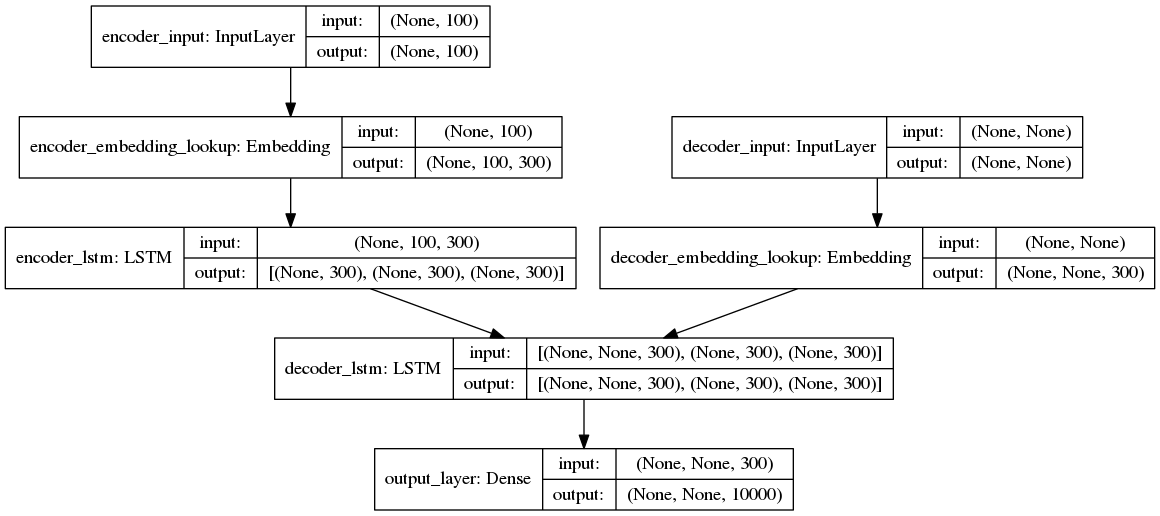

In [30]:
plot_model(model, to_file='images/full_model.png', show_layer_names=True, show_shapes=True)
Image('images/full_model.png')

### Model Training

In [31]:
# Set optimizer and loss function 
optimizer = keras.optimizers.Adam(lr=0.001) # Try a different learning rate

loss = 'categorical_crossentropy'

filepath="saved_models/seq2seq_textsummarization_{epoch:02d}_{val_loss:.4f}.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_loss', 
                                       verbose=0, 
                                       save_best_only=False)
callbacks_list = [checkpoint]

model.compile(optimizer=optimizer, loss=loss)

__Note:__ It is possible to write your own callback functions by instructing what needs to be done at the end of each epoch. <br>

Homework - write a callback function to calculate BLEU scores on validation set and print generated samples at the end of each epoch <br>
Check out https://keunwoochoi.wordpress.com/2016/07/16/keras-callbacks/

In [32]:
STEPS_PER_EPOCH = len(X_train)//BATCH_SIZE
VAL_STEPS = len(X_val)//BATCH_SIZE

In [33]:
model.fit_generator(batch_generator(X_train, Y_train, BATCH_SIZE), 
                    steps_per_epoch = STEPS_PER_EPOCH, 
                    epochs = N_EPOCHS,
                    validation_data = batch_generator(X_val, Y_val, BATCH_SIZE), 
                    validation_steps = VAL_STEPS, 
                    callbacks = callbacks_list,
                   )

Epoch 1/1
730/730 [==============================] - 300s - loss: 5.1908 - val_loss: 4.8209


__Note__: It is best to write the above code onto a .py file and execute it directly on the command line. 

We may need to train the model for over 100 epcohs to get good sentence generations. 

In this case, the model was trained for 100 epochs, about 300 seconds (~5mins) per epoch on a single GPU.

### Load Saved Model

In [34]:
from keras import models

In [35]:
model_file_path = 'saved_models/seq2seq_textsummarization_99_4.3841.h5'
model = models.load_model(model_file_path)

In [36]:
TEST_STEPS = len(X_test)//BATCH_SIZE

# Obtain the last layer output, i.e., the softmax probabilities
preds = model.predict_generator(batch_generator(X_test, Y_test, BATCH_SIZE), steps = TEST_STEPS) 

In [37]:
preds.shape

(2432, 5, 10000)

In [38]:
# Greedy Decoding
outputs = [np.argmax(p, axis = -1) for p in preds]

In [39]:
outputs[:10]

[array([52, 74,  7,  2,  2]),
 array([ 41, 163,   2,  23,   2]),
 array([1824, 2027,   93,   72,    2]),
 array([  5, 425,   2,   0,   0]),
 array([ 18,   7,   2, 114,  28]),
 array([ 16, 267,  16,  94,  49]),
 array([  4,   4, 108,   2,   2]),
 array([ 9, 12,  5, 44,  6]),
 array([ 774,   10,  594,    2, 2116]),
 array([889,  19,  19,  81,  19])]

In [40]:
def show_summary_sentence(gen_ids):
    pad = summary_word_index['PAD']
    eos = summary_word_index['EOS']
    print(' '.join([summary_idx_to_word[w] for w in gen_ids if w not in [pad, eos]]))

In [41]:
def show_input_text(inp_ids):
    pad = text_word_index['PAD']
    eos = text_word_index['EOS']
    print(' '.join([text_idx_to_word[w] for w in inp_ids if w not in [pad, eos]]))

In [42]:
for i in range(26, 30):
    show_input_text(X_test[i])
    print()
    print('Summary - ', end='')
    show_summary_sentence(outputs[i])
    print('\n----------------------------')

we buy our cats a high quality food for everyday eating and they do get cat treats which can add up when you have 4 cats i saw these on special and ordered for a great price i took the extra bags and sealed them up in food saver bags and put them in the freezer and kept one out to put in the treat jar br they love it its got all the UNK dazzle the healthy food does n t so when i give them each a little of this they think they

Summary - great price for the treats

----------------------------
this product describes itself as 100 natural arabic this is pretty much what it is coffee and a some sugar i assume that most people will be buying this for a hit of caffeine so i ll compare it to some popular alternatives br br healthy let s face it most of the other energy drinks and caffeinated sodas on the market are chemicals and water some of them throw in a couple of vitamins to give the impression that they

Summary - good those kid but

----------------------------
as always a pleasure to

In [43]:
for i, gen in enumerate(outputs[10:20]):
    print(i, end=', ')
    show_summary_sentence(gen)

0, love and
1, great great but low
2, my a great product
3, good unpleasant
4, way salty me
5, dog happy
6, caribou brew coffee cup
7, great amazingly
8, do coffee very the
9, love quality


### Is this the right way to test ?

There is no decoder input/output (Y_test) available at inference or test time!


#### Sequence-to-sequence model for __inference__:

At timestep t, we predict a target token, then use the embedding of the predicted token as input to timestep (t+1)

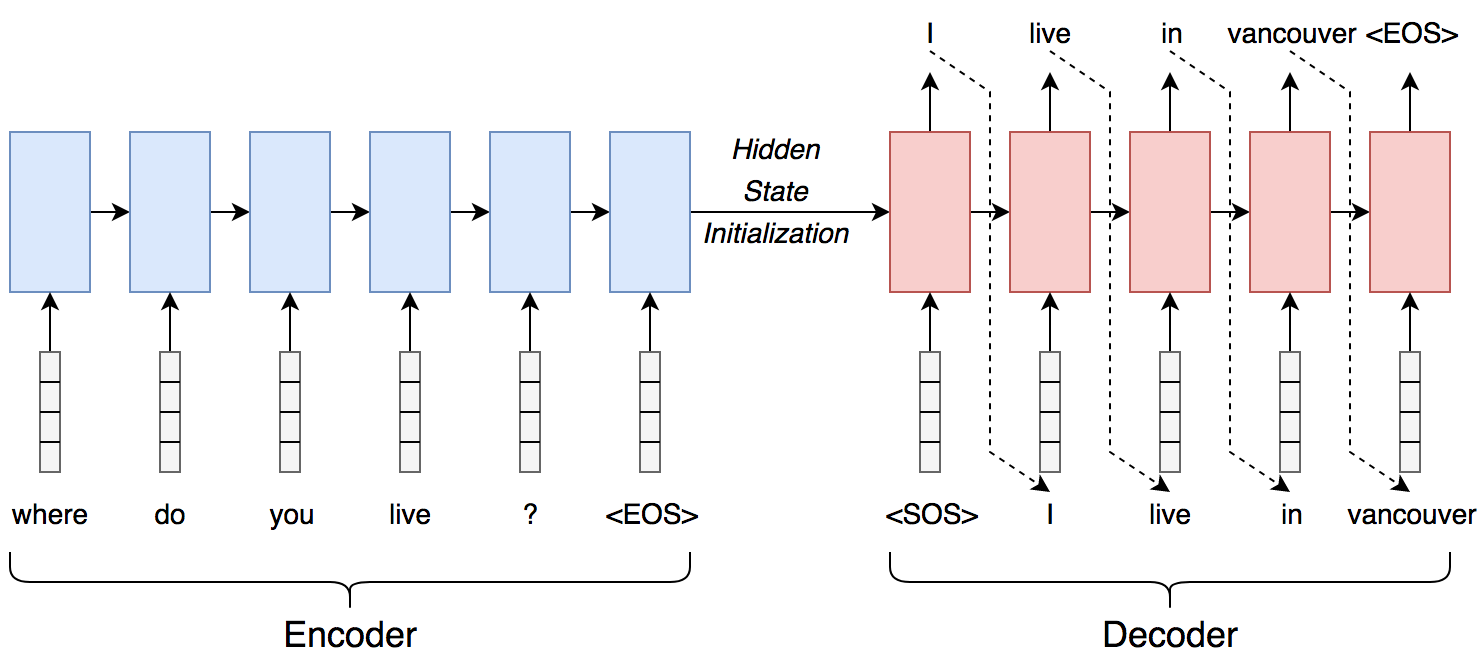

In [44]:
Image('images/seq2seq-inference.png', width=800)

#### Encoder Setup

In [45]:
encoder_model = Model(enc_input, encoder_states)
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 100)               0         
_________________________________________________________________
encoder_embedding_lookup (Em (None, 100, 300)          9000000   
_________________________________________________________________
encoder_lstm (LSTM)          [(None, 300), (None, 300) 721200    
Total params: 9,721,200
Trainable params: 721,200
Non-trainable params: 9,000,000
_________________________________________________________________


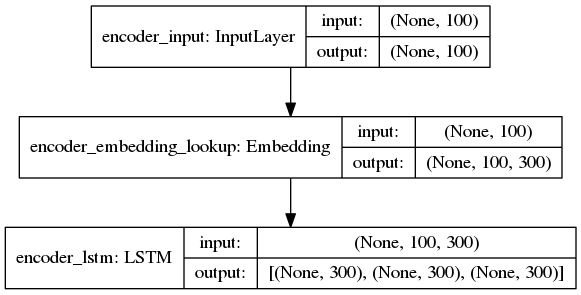

In [46]:
plot_model(encoder_model, to_file='images/encoder_model.png', show_layer_names=True, show_shapes=True)
Image('images/encoder_model.png')

#### Decoder Setup
At inference time, we predict ONE TOKEN AT A TIME
<br> Input: previous cell/hidden states and the embedding of the token from the previous time step 
<br> Output: current cell/hidden states and the output token's embedding 



In [47]:
decoder_state_input_h = Input(shape=(LSTM_DIM,), name='decoder_state_input_h')
decoder_state_input_c = Input(shape=(LSTM_DIM,), name='decoder_state_input_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(inputs=dec_emb_text, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(inputs = [dec_input] + decoder_states_inputs,
                      outputs = [decoder_outputs] + decoder_states
                     )

In [48]:
decoder_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
decoder_input (InputLayer)       (None, None)          0                                            
____________________________________________________________________________________________________
decoder_embedding_lookup (Embedd (None, None, 300)     3000000     decoder_input[0][0]              
____________________________________________________________________________________________________
decoder_state_input_h (InputLaye (None, 300)           0                                            
____________________________________________________________________________________________________
decoder_state_input_c (InputLaye (None, 300)           0                                            
___________________________________________________________________________________________

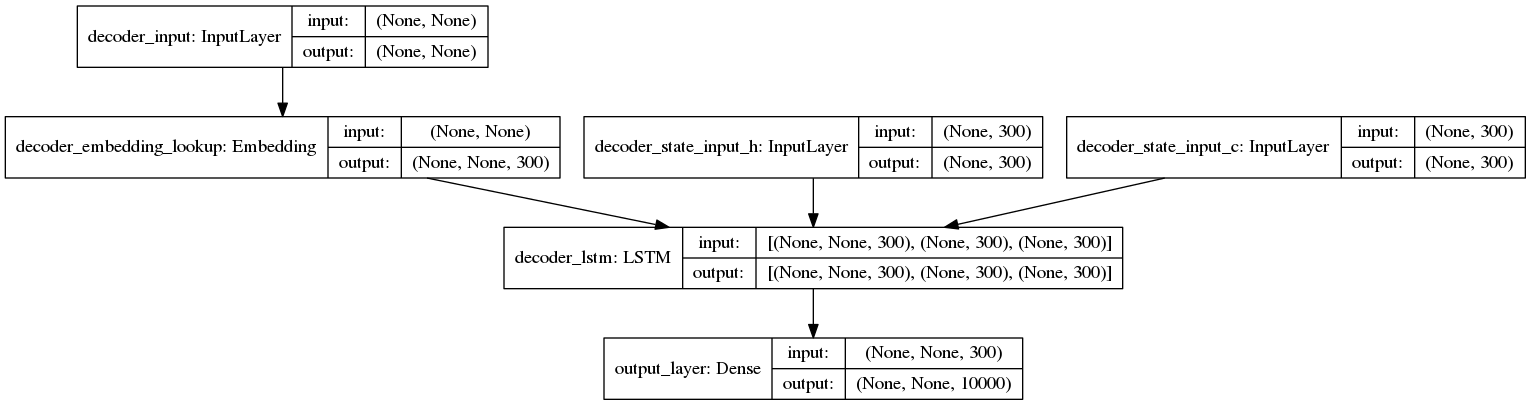

In [49]:
plot_model(decoder_model, to_file='images/decoder_model.png', show_layer_names=True, show_shapes=True)
Image('images/decoder_model.png')

### Weight Transfer
The above encoder and decoder models that we setup for inference have been initialized with random weights.

Take the weights of the trained model (that is loaded into memory) and assign the encoder and decoder models with these weights.

For weight transfer, the important thing to keep in mind is that we do not mis-align any weight matrices.

Use <br>
`model.get_weights()`  
and   
`model.set_weights()`

In [50]:
model.weights

[<tf.Variable 'encoder_lstm_1/kernel:0' shape=(300, 1200) dtype=float32_ref>,
 <tf.Variable 'encoder_lstm_1/recurrent_kernel:0' shape=(300, 1200) dtype=float32_ref>,
 <tf.Variable 'encoder_lstm_1/bias:0' shape=(1200,) dtype=float32_ref>,
 <tf.Variable 'decoder_lstm_1/kernel:0' shape=(300, 1200) dtype=float32_ref>,
 <tf.Variable 'decoder_lstm_1/recurrent_kernel:0' shape=(300, 1200) dtype=float32_ref>,
 <tf.Variable 'decoder_lstm_1/bias:0' shape=(1200,) dtype=float32_ref>,
 <tf.Variable 'output_layer_1/kernel:0' shape=(300, 10000) dtype=float32_ref>,
 <tf.Variable 'output_layer_1/bias:0' shape=(10000,) dtype=float32_ref>,
 <tf.Variable 'encoder_embedding_lookup_1/embeddings:0' shape=(30000, 300) dtype=float32_ref>,
 <tf.Variable 'decoder_embedding_lookup_1/embeddings:0' shape=(10000, 300) dtype=float32_ref>]

In [51]:
encoder_model.weights

[<tf.Variable 'encoder_lstm/kernel:0' shape=(300, 1200) dtype=float32_ref>,
 <tf.Variable 'encoder_lstm/recurrent_kernel:0' shape=(300, 1200) dtype=float32_ref>,
 <tf.Variable 'encoder_lstm/bias:0' shape=(1200,) dtype=float32_ref>,
 <tf.Variable 'encoder_embedding_lookup/embeddings:0' shape=(30000, 300) dtype=float32_ref>]

In [52]:
decoder_model.weights

[<tf.Variable 'decoder_lstm/kernel:0' shape=(300, 1200) dtype=float32_ref>,
 <tf.Variable 'decoder_lstm/recurrent_kernel:0' shape=(300, 1200) dtype=float32_ref>,
 <tf.Variable 'decoder_lstm/bias:0' shape=(1200,) dtype=float32_ref>,
 <tf.Variable 'output_layer/kernel:0' shape=(300, 10000) dtype=float32_ref>,
 <tf.Variable 'output_layer/bias:0' shape=(10000,) dtype=float32_ref>,
 <tf.Variable 'decoder_embedding_lookup/embeddings:0' shape=(10000, 300) dtype=float32_ref>]

In [53]:
model_weight_list = model.get_weights()

encoder_indices = [0, 2, 3, 4] # Index 1 is the decoder-side embedding matrix weights
encoder_weights = [model_weight_list[idx] for idx in encoder_indices]
encoder_model.set_weights(encoder_weights)

decoder_indices = list(set(range(len(model_weight_list))) - set(encoder_indices))
decoder_weights = [model_weight_list[idx] for idx in decoder_indices]
decoder_model.set_weights(decoder_weights)

In [54]:
# Specify that we are now at the inference stage, i.e., NOT learning
K.set_learning_phase(0)

In [55]:
def decode_test_sequence(test_seq_input):
    
    # Retrieve the encoder output states, h and c
    states_value = encoder_model.predict(test_seq_input)

    # Initialize the decoding process
    time_step = 0
    stop_condition = False
    input_seq_decoder = [summary_word_index['SOS']] # Start with SOS token
    output_seq = [] 

    print('Timestep | Input ----> Output')

    while not stop_condition:

        output_probs, h, c = decoder_model.predict([np.array([input_seq_decoder]), 
                                                 states_value[0], 
                                                 states_value[1]] )

        predicted_token = np.argmax(output_probs, axis=-1)[0][time_step]
        output_seq.append(predicted_token)

        print(time_step + 1, '|', input_seq_decoder, '---->', output_seq)

        time_step += 1

        # Stop iteration either when EOS is reached or when we reach the last timestep
        # Timestep is from 0 to 4. Max allowed is 4
        if (predicted_token == summary_word_index['EOS'] or time_step > MAX_SUMMARY_LEN - 1): 
                stop_condition = True
        else:
            # Create the inputs for the next iteration
            input_seq_decoder.append(predicted_token)

            states_value[0] = h
            states_value[1] = c
                
    print('\n----------------------------')
    print('Text - ', end='')
    show_input_text(test_seq_input[0])
    print()
    print('Summary - ', end='')
    show_summary_sentence(output_seq)
    
    return output_seq

In [56]:
test_seq_inp = X_test[15:16]
test_output_gen = decode_test_sequence(test_seq_inp)

Timestep | Input ----> Output
1 | [3] ----> [12]
2 | [3, 12] ----> [12, 28]
3 | [3, 12, 28] ----> [12, 28, 42]
4 | [3, 12, 28, 42] ----> [12, 28, 42, 32]
5 | [3, 12, 28, 42, 32] ----> [12, 28, 42, 32, 186]

----------------------------
Text - my dog loves them i have cut them into smaller pieces and she will chew for quite a while to finish one off i still do n t know if it helps her digestion but she sure loves them

Summary - my dog loves these eat


### Next Steps
- Monitor loss, BLEU scores and generated sentences. 
- Beam Search Decoder
- Attention Mechanism: are very helful in seq2seq models <br>
  Links: 
    <br>https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/
    <br>https://wanasit.github.io/attention-based-sequence-to-sequence-in-keras.html
        
- Visualize attention using the greyscale matrices